# xgboost参数调优 on Data Hackathon 3.x
数据集来源于Data Hackathon 3.x。该问题是一个金融行业的任务：预测Happy Customer Bank对客户发放贷款的概率。
问题描述：https://discuss.analyticsvidhya.com/t/hackathon-3-x-predict-customer-worth-for-happy-customer-bank/3802

该问题的优胜解决方案：
https://medium.com/data-science-analytics/analytics-vidhya-3-x-hackathon-9f2550b47be6
https://github.com/binga/AnalyticsVidhya_3.X_Hackathon

## 特征工程
所有的特征处理也只做最基本的参考，可自行尝试更多的特征工程工作。

### 加载需要的库:

In [1]:
import pandas as pd
import numpy as np

from matplotlib import pyplot
%matplotlib inline

import seaborn as sns

In [2]:
#载入数据:
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [3]:
train.shape, test.shape

((87020, 26), (37717, 24))

### 看看数据的基本情况

### 拿前5条出来看看

In [4]:
train.head(5)

ID  Gender       City  Monthly_Income        DOB  \
0  ID000002C20  Female      Delhi           20000  23-May-78   
1  ID000004E40    Male     Mumbai           35000  07-Oct-85   
2  ID000007H20    Male  Panchkula           22500  10-Oct-81   
3  ID000008I30    Male    Saharsa           35000  30-Nov-87   
4  ID000009J40    Male  Bengaluru          100000  17-Feb-84   

  Lead_Creation_Date  Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
0          15-May-15             300000.0                  5.0           0.0   
1          04-May-15             200000.0                  2.0           0.0   
2          19-May-15             600000.0                  4.0           0.0   
3          09-May-15            1000000.0                  5.0           0.0   
4          20-May-15             500000.0                  2.0       25000.0   

                         Employer_Name    ...    Interest_Rate Processing_Fee  \
0                              CYBOSOL    ...              NaN            NaN   
1  TATA CONSULTANCY SERVICES LTD (TCS)    ...            13.25            NaN   
2              ALCHEMIST HOSPITALS LTD    ...              NaN            NaN   
3                     BIHAR GOVERNMENT    ...              NaN            NaN   
4                 GLOBAL EDGE SOFTWARE    ...              NaN            NaN   

   EMI_Loan_Submitted Filled_Form  Device_Type  Var2  Source  Var4  LoggedIn  \
0                 NaN           N  Web-browser     G    S122     1         0   
1              6762.9           N  Web-browser     G    S122     3         0   
2                 NaN           N  Web-browser     B    S143     1         0   
3                 NaN           N  Web-browser     B    S143     3         0   
4                 NaN           N  Web-browser     B    S134     3         1   

  Disbursed  
0         0  
1         0  
2         0  
3         0  
4         0  

[5 rows x 26 columns]

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87020 entries, 0 to 87019
Data columns (total 26 columns):
ID                       87020 non-null object
Gender                   87020 non-null object
City                     86017 non-null object
Monthly_Income           87020 non-null int64
DOB                      87020 non-null object
Lead_Creation_Date       87020 non-null object
Loan_Amount_Applied      86949 non-null float64
Loan_Tenure_Applied      86949 non-null float64
Existing_EMI             86949 non-null float64
Employer_Name            86949 non-null object
Salary_Account           75256 non-null object
Mobile_Verified          87020 non-null object
Var5                     87020 non-null int64
Var1                     87020 non-null object
Loan_Amount_Submitted    52407 non-null float64
Loan_Tenure_Submitted    52407 non-null float64
Interest_Rate            27726 non-null float64
Processing_Fee           27420 non-null float64
EMI_Loan_Submitted       27726 non-null 

输入特征：
ID - 唯一ID（不能用于预测）
性别 - 性别
城市 - 当前城市
Monthly_Income - 月收入（以卢比为单位）
DOB - 出生日期
Lead_Creation_Date - Lead创建日期
Loan_Amount_Applied - 贷款申请请求金额（印度卢比，INR）
Loan_Tenure_Applied - 贷款申请期限（单位为年）
Existing_EMI -现有贷款的EMI（EMI：电子货币机构许可证） 
Employer_Name雇主名称
Salary_Account - 薪资帐户银行
Mobile_Verified - 是否移动验证（Y / N）
VAR5 - 连续型变量
VAR1-  类别型变量
Loan_Amount_Submitted - 提交的贷款金额（在看到资格后修改和选择）
Loan_Tenure_Submitted - 提交的贷款期限（单位为年，在看到资格后修改和选择）
Interest_Rate - 提交贷款金额的利率
Processing_Fee - 提交贷款的处理费（INR）
EMI_Loan_Submitted -提交的EMI贷款金额（INR）
Filled_Form - 后期报价后是否已填写申请表格
Device_Type - 进行申请的设备（浏览器/移动设备）
Var2 - 类别型变量
Source - 类别型变量
Var4 - 类别型变量

输出：
LoggedIn - 是否login（只用于理解问题的变量 - 不能用于预测，测试集中没有）
Disbursed - 是否发放贷款（目标变量）

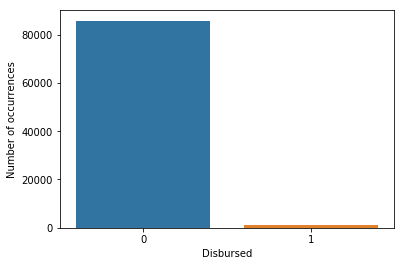

In [6]:
# Target 分布，看看各类样本分布是否均衡
sns.countplot(train.Disbursed);
pyplot.xlabel('Disbursed');
pyplot.ylabel('Number of occurrences');

In [7]:
train.describe()

Monthly_Income  Loan_Amount_Applied  Loan_Tenure_Applied  Existing_EMI  \
count    8.702000e+04         8.694900e+04         86949.000000  8.694900e+04   
mean     5.884997e+04         2.302507e+05             2.131399  3.696228e+03   
std      2.177511e+06         3.542068e+05             2.014193  3.981021e+04   
min      0.000000e+00         0.000000e+00             0.000000  0.000000e+00   
25%      1.650000e+04         0.000000e+00             0.000000  0.000000e+00   
50%      2.500000e+04         1.000000e+05             2.000000  0.000000e+00   
75%      4.000000e+04         3.000000e+05             4.000000  3.500000e+03   
max      4.445544e+08         1.000000e+07            10.000000  1.000000e+07   

               Var5  Loan_Amount_Submitted  Loan_Tenure_Submitted  \
count  87020.000000           5.240700e+04           52407.000000   
mean       4.961503           3.950106e+05               3.891369   
std        5.670385           3.082481e+05               1.165359   
min        0.000000           5.000000e+04               1.000000   
25%        0.000000           2.000000e+05               3.000000   
50%        2.000000           3.000000e+05               4.000000   
75%       11.000000           5.000000e+05               5.000000   
max       18.000000           3.000000e+06               6.000000   

       Interest_Rate  Processing_Fee  EMI_Loan_Submitted          Var4  \
count   27726.000000    27420.000000        27726.000000  87020.000000   
mean       19.197474     5131.150839        10999.528377      2.949805   
std         5.834213     4725.837644         7512.323050      1.697720   
min        11.990000      200.000000         1176.410000      0.000000   
25%        15.250000     2000.000000         6491.600000      1.000000   
50%        18.000000     4000.000000         9392.970000      3.000000   
75%        20.000000     6250.000000        12919.040000      5.000000   
max        37.000000    50000.000000       144748.280000      7.000000   

           LoggedIn     Disbursed  
count  87020.000000  87020.000000  
mean       0.029350      0.014629  
std        0.168785      0.120062  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  
max        1.000000      1.000000

In [8]:
#合成一个总的data
train['source']= 'train'
test['source'] = 'test'
data=pd.concat([train, test],ignore_index=True)
data.shape

(124737, 27)

### 数据应用/建模一个很重要的工作是检查数据质量：异常点、缺省值

In [9]:
data.apply(lambda x: sum(x.isnull()))

City                      1401
DOB                          0
Device_Type                  0
Disbursed                37717
EMI_Loan_Submitted       84901
Employer_Name              113
Existing_EMI               111
Filled_Form                  0
Gender                       0
ID                           0
Interest_Rate            84901
Lead_Creation_Date           0
Loan_Amount_Applied        111
Loan_Amount_Submitted    49535
Loan_Tenure_Applied        111
Loan_Tenure_Submitted    49535
LoggedIn                 37717
Mobile_Verified              0
Monthly_Income               0
Processing_Fee           85346
Salary_Account           16801
Source                       0
Var1                         0
Var2                         0
Var4                         0
Var5                         0
source                       0
dtype: int64

### 这些字段分别有多少种取值，也可以可以看看分布

In [10]:
var = ['Gender','Salary_Account','Mobile_Verified','Var1','Filled_Form','Device_Type','Var2','Source']
for v in var:
    print '\n%s属性的不同取值和出现的次数\n'%v
    print data[v].value_counts()


Gender属性的不同取值和出现的次数

Male      71398
Female    53339
Name: Gender, dtype: int64

Salary_Account属性的不同取值和出现的次数

HDFC Bank                                          25180
ICICI Bank                                         19547
State Bank of India                                17110
Axis Bank                                          12590
Citibank                                            3398
Kotak Bank                                          2955
IDBI Bank                                           2213
Punjab National Bank                                1747
Bank of India                                       1713
Bank of Baroda                                      1675
Standard Chartered Bank                             1434
Canara Bank                                         1385
Union Bank of India                                 1330
Yes Bank                                            1120
ING Vysya                                            996
Corporation bank                  

### City

In [11]:
len(data['City'].unique())

724

#### city的取值很多，在此粗暴抛弃
也可以保留最常见的10个城市，其他城市编码成非主要城市

In [12]:
data.drop('City',axis=1,inplace=True)

### DOB
DOB是出生的具体日期，具体日期可能没作用，转换成年龄段

In [13]:
data['DOB'].head()

0    23-May-78
1    07-Oct-85
2    10-Oct-81
3    30-Nov-87
4    17-Feb-84
Name: DOB, dtype: object

In [14]:
#创建一个年龄的字段Age
#因为竞赛在2015年举行，所以用15+100减去年份（最后两位）
data['Age'] = data['DOB'].apply(lambda x: 115 - int(x[-2:]))
data['Age'].head()

0    37
1    30
2    34
3    28
4    31
Name: Age, dtype: int64

In [15]:
#把原始的DOB字段去掉:
data.drop('DOB',axis=1,inplace=True)

### EMI_Load_Submitted字段处理

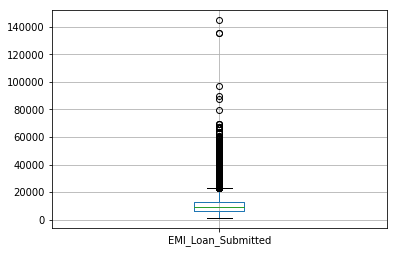

In [16]:
data.boxplot(column=['EMI_Loan_Submitted'],return_type='axes')

In [17]:
#缺失值比较多，干脆就开一个新的字段，表明是缺失值还是不是缺失值
data['EMI_Loan_Submitted_Missing'] = data['EMI_Loan_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)
data[['EMI_Loan_Submitted','EMI_Loan_Submitted_Missing']].head(10)

EMI_Loan_Submitted  EMI_Loan_Submitted_Missing
0                 NaN                           1
1             6762.90                           0
2                 NaN                           1
3                 NaN                           1
4                 NaN                           1
5             6978.92                           0
6                 NaN                           1
7                 NaN                           1
8            30824.65                           0
9            10883.38                           0

In [18]:
#原始那一列就可以不要了
#xgboost可以处理缺失值，可以保留，而且保留的话，xgboost还认为这是一个很重要的特征，仅次于月收入特征....
data.drop('EMI_Loan_Submitted',axis=1,inplace=True)

### Employer Name字段处理

#### 看看个数

In [19]:
len(data['Employer_Name'].value_counts())

57193

#### 名字的取值太多了，可以直接drop掉
类似City字段

In [20]:
#丢掉
data.drop('Employer_Name',axis=1,inplace=True)

### Existing_EMI字段

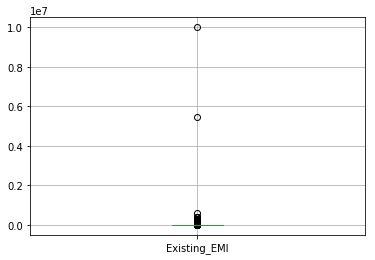

In [21]:
data.boxplot(column='Existing_EMI',return_type='axes')

似乎有两个outlier，可以考虑去掉，不过xgboost对outlier不太敏感

In [22]:
data['Existing_EMI'].describe()

count    1.246260e+05
mean     3.636342e+03
std      3.369124e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      3.500000e+03
max      1.000000e+07
Name: Existing_EMI, dtype: float64

In [23]:
#缺省值不多，用0代替
# xgboost其实可以不用处理缺失值，xgboost可以自己处理
data['Existing_EMI'].fillna(0, inplace=True)

### Interest_Rate字段:

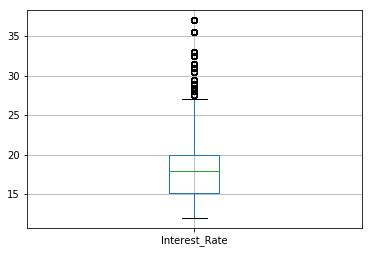

In [24]:
data.boxplot(column=['Interest_Rate'],return_type='axes')

In [25]:
#缺省值太多，也造一个字段，表示有无
data['Interest_Rate_Missing'] = data['Interest_Rate'].apply(lambda x: 1 if pd.isnull(x) else 0)
print data[['Interest_Rate','Interest_Rate_Missing']].head(10)

   Interest_Rate  Interest_Rate_Missing
0            NaN                      1
1          13.25                      0
2            NaN                      1
3            NaN                      1
4            NaN                      1
5          13.99                      0
6            NaN                      1
7            NaN                      1
8          14.85                      0
9          18.25                      0


In [26]:
data.drop('Interest_Rate',axis=1,inplace=True)

### Lead Creation Date字段

In [27]:
#drop
data.drop('Lead_Creation_Date',axis=1,inplace=True)
data.head()

Device_Type  Disbursed  Existing_EMI Filled_Form  Gender           ID  \
0  Web-browser        0.0           0.0           N  Female  ID000002C20   
1  Web-browser        0.0           0.0           N    Male  ID000004E40   
2  Web-browser        0.0           0.0           N    Male  ID000007H20   
3  Web-browser        0.0           0.0           N    Male  ID000008I30   
4  Web-browser        0.0       25000.0           N    Male  ID000009J40   

   Loan_Amount_Applied  Loan_Amount_Submitted  Loan_Tenure_Applied  \
0             300000.0                    NaN                  5.0   
1             200000.0               200000.0                  2.0   
2             600000.0               450000.0                  4.0   
3            1000000.0               920000.0                  5.0   
4             500000.0               500000.0                  2.0   

   Loan_Tenure_Submitted          ...                 Salary_Account Source  \
0                    NaN          ...                      HDFC Bank   S122   
1                    2.0          ...                     ICICI Bank   S122   
2                    4.0          ...            State Bank of India   S143   
3                    5.0          ...            State Bank of India   S143   
4                    2.0          ...                      HDFC Bank   S134   

   Var1  Var2 Var4 Var5 source Age  EMI_Loan_Submitted_Missing  \
0  HBXX     G    1    0  train  37                           1   
1  HBXA     G    3   13  train  30                           0   
2  HBXX     B    1    0  train  34                           1   
3  HBXX     B    3   10  train  28                           1   
4  HBXX     B    3   17  train  31                           1   

   Interest_Rate_Missing  
0                      1  
1                      0  
2                      1  
3                      1  
4                      1  

[5 rows x 24 columns]

### Loan Amount and Tenure applied字段

In [28]:
#找中位数去填补缺省值（因为缺省的不多）
data['Loan_Amount_Applied'].fillna(data['Loan_Amount_Applied'].median(),inplace=True)
data['Loan_Tenure_Applied'].fillna(data['Loan_Tenure_Applied'].median(),inplace=True)

In [29]:
data.head()

Device_Type  Disbursed  Existing_EMI Filled_Form  Gender           ID  \
0  Web-browser        0.0           0.0           N  Female  ID000002C20   
1  Web-browser        0.0           0.0           N    Male  ID000004E40   
2  Web-browser        0.0           0.0           N    Male  ID000007H20   
3  Web-browser        0.0           0.0           N    Male  ID000008I30   
4  Web-browser        0.0       25000.0           N    Male  ID000009J40   

   Loan_Amount_Applied  Loan_Amount_Submitted  Loan_Tenure_Applied  \
0             300000.0                    NaN                  5.0   
1             200000.0               200000.0                  2.0   
2             600000.0               450000.0                  4.0   
3            1000000.0               920000.0                  5.0   
4             500000.0               500000.0                  2.0   

   Loan_Tenure_Submitted          ...                 Salary_Account Source  \
0                    NaN          ...                      HDFC Bank   S122   
1                    2.0          ...                     ICICI Bank   S122   
2                    4.0          ...            State Bank of India   S143   
3                    5.0          ...            State Bank of India   S143   
4                    2.0          ...                      HDFC Bank   S134   

   Var1  Var2 Var4 Var5 source Age  EMI_Loan_Submitted_Missing  \
0  HBXX     G    1    0  train  37                           1   
1  HBXA     G    3   13  train  30                           0   
2  HBXX     B    1    0  train  34                           1   
3  HBXX     B    3   10  train  28                           1   
4  HBXX     B    3   17  train  31                           1   

   Interest_Rate_Missing  
0                      1  
1                      0  
2                      1  
3                      1  
4                      1  

[5 rows x 24 columns]

### Loan Amount and Tenure selected

In [30]:
# 缺省值太多。。。是否缺省。。。
#个人建议Loan_Amount_Submitted为空，表示得到资格后没有修改，用Loan_Amount_Applied代替比较好
data['Loan_Amount_Submitted_Missing'] = data['Loan_Amount_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)
data['Loan_Tenure_Submitted_Missing'] = data['Loan_Tenure_Submitted'].apply(lambda x: 1 if pd.isnull(x) else 0)

In [31]:
data.head()

Device_Type  Disbursed  Existing_EMI Filled_Form  Gender           ID  \
0  Web-browser        0.0           0.0           N  Female  ID000002C20   
1  Web-browser        0.0           0.0           N    Male  ID000004E40   
2  Web-browser        0.0           0.0           N    Male  ID000007H20   
3  Web-browser        0.0           0.0           N    Male  ID000008I30   
4  Web-browser        0.0       25000.0           N    Male  ID000009J40   

   Loan_Amount_Applied  Loan_Amount_Submitted  Loan_Tenure_Applied  \
0             300000.0                    NaN                  5.0   
1             200000.0               200000.0                  2.0   
2             600000.0               450000.0                  4.0   
3            1000000.0               920000.0                  5.0   
4             500000.0               500000.0                  2.0   

   Loan_Tenure_Submitted              ...                Var1 Var2  Var4  \
0                    NaN              ...                HBXX    G     1   
1                    2.0              ...                HBXA    G     3   
2                    4.0              ...                HBXX    B     1   
3                    5.0              ...                HBXX    B     3   
4                    2.0              ...                HBXX    B     3   

   Var5 source Age EMI_Loan_Submitted_Missing Interest_Rate_Missing  \
0     0  train  37                          1                     1   
1    13  train  30                          0                     0   
2     0  train  34                          1                     1   
3    10  train  28                          1                     1   
4    17  train  31                          1                     1   

   Loan_Amount_Submitted_Missing  Loan_Tenure_Submitted_Missing  
0                              1                              1  
1                              0                              0  
2                              0                              0  
3                              0                              0  
4                              0                              0  

[5 rows x 26 columns]

In [32]:
#原来的字段就没用了
data.drop(['Loan_Amount_Submitted','Loan_Tenure_Submitted'],axis=1,inplace=True)

### LoggedIn

In [33]:
#没想好怎么用
data.drop('LoggedIn',axis=1,inplace=True)

### salary account

In [34]:
# 可能对接多个银行，所以也不要了
#data.drop('Salary_Account',axis=1,inplace=True)

def dictMap(listOfMajors, non_major):
    mapped_dict = {}
    for i, major in enumerate(reversed(listOfMajors)):
        mapped_dict[major] = (i+1)
    mapped_dict[non_major] = 0
    return mapped_dict

#训练集中前20个银行为主要银行，其他编码为非主要银行
#City，Employer_Name等字段亦可采用这种方式
bank_counts = train.Salary_Account.value_counts()
major_banks = list(bank_counts.index[:20])

data.loc[ ~data['Salary_Account'].isin(major_banks), 'Salary_Account' ] = 'Non-major bank'
mapped_banks = dictMap(major_banks, 'Non-major bank')

#编码成整数
data['Salary_Account'] = data['Salary_Account'].map( mapped_banks ).astype(int)

### Processing_Fee

In [35]:
#和之前一样的处理，有或者没有
data['Processing_Fee_Missing'] = data['Processing_Fee'].apply(lambda x: 1 if pd.isnull(x) else 0)
#旧的字段不要了
data.drop('Processing_Fee',axis=1,inplace=True)

### Source

In [36]:
data['Source'] = data['Source'].apply(lambda x: 'others' if x not in ['S122','S133'] else x)
data['Source'].value_counts()

S122      55249
S133      42900
others    26588
Name: Source, dtype: int64

## 最终的数据样式

In [37]:
data.head()

Device_Type  Disbursed  Existing_EMI Filled_Form  Gender           ID  \
0  Web-browser        0.0           0.0           N  Female  ID000002C20   
1  Web-browser        0.0           0.0           N    Male  ID000004E40   
2  Web-browser        0.0           0.0           N    Male  ID000007H20   
3  Web-browser        0.0           0.0           N    Male  ID000008I30   
4  Web-browser        0.0       25000.0           N    Male  ID000009J40   

   Loan_Amount_Applied  Loan_Tenure_Applied Mobile_Verified  Monthly_Income  \
0             300000.0                  5.0               N           20000   
1             200000.0                  2.0               Y           35000   
2             600000.0                  4.0               Y           22500   
3            1000000.0                  5.0               Y           35000   
4             500000.0                  2.0               Y          100000   

            ...            Var2 Var4 Var5 source  Age  \
0           ...               G    1    0  train   37   
1           ...               G    3   13  train   30   
2           ...               B    1    0  train   34   
3           ...               B    3   10  train   28   
4           ...               B    3   17  train   31   

   EMI_Loan_Submitted_Missing Interest_Rate_Missing  \
0                           1                     1   
1                           0                     0   
2                           1                     1   
3                           1                     1   
4                           1                     1   

   Loan_Amount_Submitted_Missing  Loan_Tenure_Submitted_Missing  \
0                              1                              1   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   Processing_Fee_Missing  
0                       1  
1                       1  
2                       1  
3                       1  
4                       1  

[5 rows x 23 columns]

In [38]:
data.describe()

Disbursed  Existing_EMI  Loan_Amount_Applied  Loan_Tenure_Applied  \
count  87020.000000  1.247370e+05         1.247370e+05        124737.000000   
mean       0.014629  3.633107e+03         2.298744e+05             2.138075   
std        0.120062  3.367642e+04         3.539938e+05             2.014874   
min        0.000000  0.000000e+00         0.000000e+00             0.000000   
25%        0.000000  0.000000e+00         0.000000e+00             0.000000   
50%        0.000000  0.000000e+00         1.000000e+05             2.000000   
75%        0.000000  3.500000e+03         3.000000e+05             4.000000   
max        1.000000  1.000000e+07         1.500000e+07            10.000000   

       Monthly_Income  Salary_Account           Var4           Var5  \
count    1.247370e+05   124737.000000  124737.000000  124737.000000   
mean     5.309073e+04       13.250631       2.950560       4.964774   
std      1.823394e+06        7.807525       1.695261       5.669784   
min      0.000000e+00        0.000000       0.000000       0.000000   
25%      1.650000e+04        6.000000       1.000000       0.000000   
50%      2.500000e+04       17.000000       3.000000       2.000000   
75%      4.000000e+04       19.000000       5.000000      11.000000   
max      4.445544e+08       20.000000       7.000000      18.000000   

                 Age  EMI_Loan_Submitted_Missing  Interest_Rate_Missing  \
count  124737.000000               124737.000000          124737.000000   
mean       30.906996                    0.680640               0.680640   
std         7.137860                    0.466231               0.466231   
min        18.000000                    0.000000               0.000000   
25%        26.000000                    0.000000               0.000000   
50%        29.000000                    1.000000               1.000000   
75%        34.000000                    1.000000               1.000000   
max       100.000000                    1.000000               1.000000   

       Loan_Amount_Submitted_Missing  Loan_Tenure_Submitted_Missing  \
count                  124737.000000                  124737.000000   
mean                        0.397116                       0.397116   
std                         0.489302                       0.489302   
min                         0.000000                       0.000000   
25%                         0.000000                       0.000000   
50%                         0.000000                       0.000000   
75%                         1.000000                       1.000000   
max                         1.000000                       1.000000   

       Processing_Fee_Missing  
count           124737.000000  
mean                 0.684208  
std                  0.464833  
min                  0.000000  
25%                  0.000000  
50%                  1.000000  
75%                  1.000000  
max                  1.000000

In [39]:
data.apply(lambda x: sum(x.isnull()))

Device_Type                          0
Disbursed                        37717
Existing_EMI                         0
Filled_Form                          0
Gender                               0
ID                                   0
Loan_Amount_Applied                  0
Loan_Tenure_Applied                  0
Mobile_Verified                      0
Monthly_Income                       0
Salary_Account                       0
Source                               0
Var1                                 0
Var2                                 0
Var4                                 0
Var5                                 0
source                               0
Age                                  0
EMI_Loan_Submitted_Missing           0
Interest_Rate_Missing                0
Loan_Amount_Submitted_Missing        0
Loan_Tenure_Submitted_Missing        0
Processing_Fee_Missing               0
dtype: int64

In [40]:
data.dtypes

Device_Type                       object
Disbursed                        float64
Existing_EMI                     float64
Filled_Form                       object
Gender                            object
ID                                object
Loan_Amount_Applied              float64
Loan_Tenure_Applied              float64
Mobile_Verified                   object
Monthly_Income                     int64
Salary_Account                     int64
Source                            object
Var1                              object
Var2                              object
Var4                               int64
Var5                               int64
source                            object
Age                                int64
EMI_Loan_Submitted_Missing         int64
Interest_Rate_Missing              int64
Loan_Amount_Submitted_Missing      int64
Loan_Tenure_Submitted_Missing      int64
Processing_Fee_Missing             int64
dtype: object

### 数值编码

In [41]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
var_to_encode = ['Device_Type','Filled_Form','Gender','Var1','Var2','Mobile_Verified','Source']
for col in var_to_encode:
    data[col] = le.fit_transform(data[col])

In [42]:
data.head()

Device_Type  Disbursed  Existing_EMI  Filled_Form  Gender           ID  \
0            1        0.0           0.0            0       0  ID000002C20   
1            1        0.0           0.0            0       1  ID000004E40   
2            1        0.0           0.0            0       1  ID000007H20   
3            1        0.0           0.0            0       1  ID000008I30   
4            1        0.0       25000.0            0       1  ID000009J40   

   Loan_Amount_Applied  Loan_Tenure_Applied  Mobile_Verified  Monthly_Income  \
0             300000.0                  5.0                0           20000   
1             200000.0                  2.0                1           35000   
2             600000.0                  4.0                1           22500   
3            1000000.0                  5.0                1           35000   
4             500000.0                  2.0                1          100000   

            ...            Var2  Var4  Var5  source  Age  \
0           ...               6     1     0   train   37   
1           ...               6     3    13   train   30   
2           ...               1     1     0   train   34   
3           ...               1     3    10   train   28   
4           ...               1     3    17   train   31   

   EMI_Loan_Submitted_Missing Interest_Rate_Missing  \
0                           1                     1   
1                           0                     0   
2                           1                     1   
3                           1                     1   
4                           1                     1   

   Loan_Amount_Submitted_Missing  Loan_Tenure_Submitted_Missing  \
0                              1                              1   
1                              0                              0   
2                              0                              0   
3                              0                              0   
4                              0                              0   

   Processing_Fee_Missing  
0                       1  
1                       1  
2                       1  
3                       1  
4                       1  

[5 rows x 23 columns]

In [43]:
data.dtypes

Device_Type                        int64
Disbursed                        float64
Existing_EMI                     float64
Filled_Form                        int64
Gender                             int64
ID                                object
Loan_Amount_Applied              float64
Loan_Tenure_Applied              float64
Mobile_Verified                    int64
Monthly_Income                     int64
Salary_Account                     int64
Source                             int64
Var1                               int64
Var2                               int64
Var4                               int64
Var5                               int64
source                            object
Age                                int64
EMI_Loan_Submitted_Missing         int64
Interest_Rate_Missing              int64
Loan_Amount_Submitted_Missing      int64
Loan_Tenure_Submitted_Missing      int64
Processing_Fee_Missing             int64
dtype: object

### 类别型的One-Hot 编码

In [44]:
data = pd.get_dummies(data, columns=var_to_encode)
data.columns

Index([u'Disbursed', u'Existing_EMI', u'ID', u'Loan_Amount_Applied',
       u'Loan_Tenure_Applied', u'Monthly_Income', u'Salary_Account', u'Var4',
       u'Var5', u'source', u'Age', u'EMI_Loan_Submitted_Missing',
       u'Interest_Rate_Missing', u'Loan_Amount_Submitted_Missing',
       u'Loan_Tenure_Submitted_Missing', u'Processing_Fee_Missing',
       u'Device_Type_0', u'Device_Type_1', u'Filled_Form_0', u'Filled_Form_1',
       u'Gender_0', u'Gender_1', u'Var1_0', u'Var1_1', u'Var1_2', u'Var1_3',
       u'Var1_4', u'Var1_5', u'Var1_6', u'Var1_7', u'Var1_8', u'Var1_9',
       u'Var1_10', u'Var1_11', u'Var1_12', u'Var1_13', u'Var1_14', u'Var1_15',
       u'Var1_16', u'Var1_17', u'Var1_18', u'Var2_0', u'Var2_1', u'Var2_2',
       u'Var2_3', u'Var2_4', u'Var2_5', u'Var2_6', u'Mobile_Verified_0',
       u'Mobile_Verified_1', u'Source_0', u'Source_1', u'Source_2'],
      dtype='object')

### 区分训练和测试数据

In [45]:
train = data.loc[data['source']=='train']
test = data.loc[data['source']=='test']

In [46]:
train.drop('source',axis=1,inplace=True)
test.drop(['source','Disbursed'],axis=1,inplace=True)

/Users/qing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/qing/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [47]:
train.to_csv('train_modified.csv',index=False)
test.to_csv('test_modified.csv',index=False)